<a href="https://colab.research.google.com/github/Mario-RJunior/classificador-sentimento-NLP/blob/main/classificador_sentimento_RNC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificador de Sentimento

## 1) Introdução

Neste projeto iremos desenvolver um classificador de sentimentos e para isso utilizaremos uma base contendo dados de usuários do Twitter.

Esta base estará estruturada da seguinte com as seguintes colunas:
- ***sentiment***: 0 e 1 (negativo e positivo).
- ***id***: número de identificação do comentário.
- ***date***: data da postagem.
- ***query***: pesquisa realizada.
-	***user***: usuário da postagem.
- ***text***: texto que queremos classificar.

Agora, iremos importar as bibliotecas que usaremos neste estudo.

## 2) Importação das bibliotecas

In [ ]:
# Importando as bibliotecas
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
from google.colab import drive
import zipfile
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt

In [ ]:
# Selecionando a versão do tensorflow
%tensorflow_version 2.x

# importando o tensorflow
import tensorflow as tf

# Visualizando a versão do tensorflow
tf.__version__

'2.4.0'

In [ ]:
# Importando recursos específicos do tensorflow
from tensorflow.keras import layers
import tensorflow_datasets as tfds

## 3) Pré-processamento dos dados

### 3.1) Carregamento dos arquivos

In [ ]:
# Conectando com o Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Caminho para acesso ao arquivo
path = '/content/drive/MyDrive/NLP/trainingandtestdata.zip'

# Descompactando o arquivo
zip_object = zipfile.ZipFile(path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [ ]:
# Criando colunas para usar no dataframe
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [ ]:
# Criando dataframe
train_data = pd.read_csv('/content/trainingandtestdata/train.csv', 
                        encoding='latin1',
                        names=cols,
                        header=None,
                        engine='python')

In [ ]:
# Visualizando o shape do dataframe
train_data.shape

(1600000, 6)

In [ ]:
# Visualizando os primeiros registros
train_data.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Visualizando os últimos registros
train_data.tail()

,sentiment,id,date,query,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [ ]:
# Visualizando os valores da classe
train_data['sentiment'].unique()

array([0, 4])

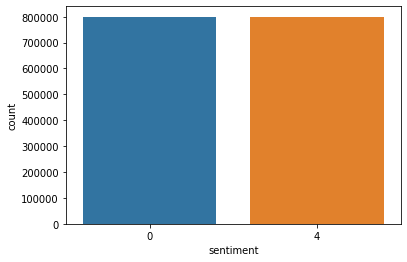

In [ ]:
# Contagem da classe
sns.countplot(data=train_data, x='sentiment');

Vemos, portanto, que a base não está desbalanceada. Criaremos agora a base de testes.



In [ ]:
# Criação da base de testes
test_data = pd.read_csv('/content/trainingandtestdata/test.csv', 
                        encoding='latin1',
                        names=cols,
                        header=None,
                        engine='python')

In [ ]:
# Visualizando os primeiros registros
test_data.head()

,sentiment,id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [ ]:
# Visualizando o shape
test_data.shape

(498, 6)

In [ ]:
# Valores únicos dos sentimentos da base de testes
test_data['sentiment'].unique()

array([4, 0, 2])

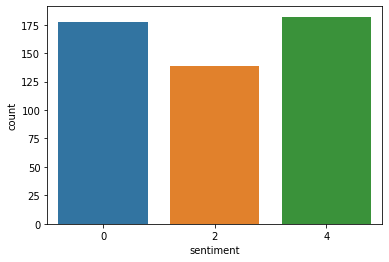

In [ ]:
# Contagem da classe
sns.countplot(data=test_data, x='sentiment');

Notamos que a base de testes tem uma estrutura diferente dos "sentimentos" em relação à base de treinos, apresentando um sentimento "neutro". Por isso não iremos utilizá-la e faremos toda a nossa análise na própria base de treinos.

### 3.2) Separando a base de dados

Antes de fazer a limpeza iremos criar um outro dataframe excluindo as colunas desnecessárias e a seguir separaremos uma amostra com 15% da base original para fazer o treinamento do modelo.

In [ ]:
# Criando novo dataframe
data = train_data

# Deletando colunas desnecessárias
data.drop(axis=1, columns=['id', 'date', 'query', 'user'], inplace=True)

# Visualizando o novo dataframe
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


- Criando feature e classe

In [ ]:
# Feature dos textos
X = data.iloc[:, 1].values

# Classe
y = data.iloc[:, 0].values

In [ ]:
# Visualizando o array X
X

array(["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
       "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
       '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
       ..., 'Are you ready for your MoJo Makeover? Ask me for details ',
       'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur ',
       'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H '],
      dtype=object)

In [ ]:
# Visualizando o array y
y

array([0, 0, 0, ..., 4, 4, 4])

Como a base de dados é muito grande (1600000 registros) iremos separar uma amostra (15%) desta base para fazermos o treinamento. Assim, segue o código abaixo.

In [ ]:
# Importando a biblioteca
from sklearn.model_selection import train_test_split

# Pegando uma amostra da base original
X, _, y, _ = train_test_split(X, y, test_size=0.85, stratify=y)

In [ ]:
# Visualizando o shape
X.shape, y.shape

((240000,), (240000,))

In [ ]:
# Valores únicos e suas quantidades
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0, 4]), array([120000, 120000]))

### 3.3) Limpeza dos textos

Nesta subção iremos limpar de fato os textos e para isso criaremos uma função que fará o trabalho. Para teste, usaremos um texto aleatório da base de dados.

In [ ]:
# Criando a função
def clean_tweets(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r'@[A-Za-z0-9_]+', ' ', tweet)
  tweet = re.sub(r'https?://[A-Za-z0-9./]+', ' ', tweet)
  tweet = re.sub(r'[^A-Za-z.!?]', ' ', tweet)
  tweet = re.sub(r' +', ' ', tweet).strip()
  return tweet

In [ ]:
# Criando um texto qualquer para teste
text = data['text'][0]
text

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [ ]:
# Testando a função
text = clean_tweets(text)
text

'Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D'

- Remoção de stop words

Iremos aqui escrever uma função para remoção de stop words dos tweets.

In [ ]:
# Criando um objeto para lingua inglesa
nlp = sp.load('en')
nlp

In [ ]:
# Criando lista de stop words
stop_words = sp.lang.en.STOP_WORDS
print(stop_words)

{'below', 'both', 'thereby', 'is', 'too', 'where', 'again', 'among', 'five', "'d", 'toward', 'yourself', 'four', 'therefore', 'hereby', 'was', 'wherever', 'former', 'why', 'you', 'her', 'within', 'top', 'doing', 'if', 'not', 'rather', 'moreover', 'part', '‘re', '’re', 'a', 'between', 'name', 'n‘t', 'hereupon', 'whereupon', 'everywhere', 'his', 'still', 'mine', 'since', 'them', 'whom', '‘d', 'fifteen', 'whereas', 'against', 'while', 'she', 'under', 'there', 'has', 'cannot', 'thru', 'whole', 'through', 'neither', '‘m', 'our', 'almost', 'are', 'empty', '’d', '’ve', 'twelve', 'mostly', 'seemed', 'when', '‘ve', 'hereafter', 'at', 'in', 'indeed', 'this', 'because', 'becomes', 'done', 'either', 'itself', 'least', 'next', 'although', 'put', 'somehow', 'anywhere', 'being', 'other', 'anyhow', 'hence', 'from', 'besides', 'everything', "'ll", 'eleven', 'could', 'but', 'to', 'which', 'seems', 'these', 'than', 'afterwards', 'say', 'thence', 'whither', 'above', 'back', 'go', 'much', 'beside', 'hundre

In [ ]:
# Contando total de stop words
len(stop_words)

326

In [ ]:
# Função para remover stop words
def remove_stop_words(tweet):
  tweet = tweet.lower()
  document = nlp(tweet)

  words = [token.text for token in document]
  words = [word for word in words if word not in stop_words \
           and word not in string.punctuation]
  words = ' '.join(words)

  return words

In [ ]:
remove_stop_words(text)

'awww s bummer shoulda got david carr day d'

Para realmente fazermos a limpeza dos textos iremos juntar as duas funções anteriores em apenas uma para otimizar este trabalho.

In [ ]:
# Criando a função final
def clean_tweets2(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r'@[A-Za-z0-9_]+', ' ', tweet)
  tweet = re.sub(r'https?://[A-Za-z0-9./]+', ' ', tweet)
  tweet = re.sub(r'[^A-Za-z.!?]', ' ', tweet)
  tweet = re.sub(r' +', ' ', tweet).strip()

  tweet = tweet.lower()
  document = nlp(tweet)

  words = [token.text for token in document]
  words = [word for word in words if word not in stop_words \
           and word not in string.punctuation]
  words = ' '.join(words)
  return words

- Limpeza de todos os reviews

Iremos testar a função acima.

In [ ]:
# Definindo a variável contendo um review
text2 = data['text'][0]
text2

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [ ]:
# Aplicando a função acima
text2 = clean_tweets2(text2)
text2

'awww s bummer shoulda got david carr day d'

Agora sim aplicaremos a função nos reviews.

In [ ]:
# Criando variável com reviews limpos
data_clean = [clean_tweets(tweet) for tweet in X]

In [ ]:
# Retornando alguns registros aleatoriamente
for _ in range(10):
  print(data_clean[random.randint(0, len(data_clean) - 1)])

So glad to hear that I m doing great thank you! Enjoying doing a lil window shopping tonight!
The search is on
well good night my followers wish i had more
Like what? There s nothing to do
we got outbid by .
when will u Guys LEARN!
Hawt.did such a good workout.could have all the nutella I wanted now.but instead having a banana protein shake.
I know the feeling sigh
Watching a rather strange but good Bones
Cool but having only dollars as payment sucks lol I mean i cannot pay or get paid Snif!But i will upload some designs for sure


Uma outra alteração que devemos fazer é na variável y, uma vez que ela apresenta valores 0 e 4 para comentários negativos e positivos respectivamente. Então substituiremos por 0 e 1.

In [ ]:
# Definindo a variável
data_labels = y
np.unique(data_labels)

array([0, 4])

In [ ]:
# Alterando de 4 para 1
data_labels[data_labels == 4] = 1

In [ ]:
# Confirmando a alteração
np.unique(data_labels)

array([0, 1])

### 3.4) Tokenização

O processo de tokenização consiste em converter todos os textos em números. Este processo é extremamente necessário uma vez que iremos trabalhar com algorítmos que não aceitam dados no formato "string".

In [ ]:
# Criando objeto para tokenização
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean,
                                                                      target_vocab_size=2**16)

In [ ]:
# Verificando tamanho do vocabulário
tokenizer.vocab_size

67964

Note que iremos utilizar um vocabulário contendo 67964 palavras. 

A seguir iremos de fato tokenizar o vocabulário e para isso faremos um teste para verificar como funciona o processo.

In [ ]:
# Criando id's de teste para texto qualquer
ids = tokenizer.encode('i am happy')
ids

[6, 55, 645]

In [ ]:
# Decodificando os id's
text = tokenizer.decode(ids)
text

'i am happy'

Assim, notamos que nosso tokenizador está funcionando corretamente. Aplicaremos agora este mesmo processo para os comentários da nossa base.

In [ ]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [ ]:
# Retornando alguns registros aleatoriamente após tokenização
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[1, 21, 603, 17, 194, 3907, 8, 535, 4286, 5971, 53, 584, 21, 6058, 13995]
[447, 15032, 27852, 5459, 32, 258, 10, 279, 47, 51, 35, 253, 16, 779, 2, 125, 12, 580, 24]
[1, 126, 63201, 54532, 67740, 500, 330, 141, 61, 12, 489, 12, 2192]
[2989, 8, 7089]
[41787, 67740, 13, 11, 37, 4, 11344, 1311, 17, 584, 17, 196, 7462, 129]
[59590, 12, 13, 81, 14, 334, 3, 6, 88, 358, 16, 1236, 39, 26, 7, 680, 281, 413, 3, 7, 905, 38, 520, 7464]
[60999, 35, 7333, 67771]
[67, 23, 1, 3057, 4277, 27, 5, 2489, 1865]
[170, 14, 4, 9798, 9, 115, 8, 5886, 8107, 4, 313, 578, 3, 1736, 27, 189, 67741]
[197, 71, 50874, 822, 15, 5, 434, 31116, 41911, 369, 355, 1, 19, 131, 465, 1, 19, 22, 645, 9, 35781, 531, 13, 2261]


### 3.5) Padding (preenchimento)

Na última subseção fizemos a tokenização dos tweets e obtemos cada um deles na forma de id's, com cada palavra tendo seu id único. Mas note do último resultado que, dependendo do tamanho, o tweet pode ter números diferentes de id's. Desta forma, teremos que deixar todos as listas representando os tokens com o mesmo tamanho e para isso faremos um processo conhecido como ***padding*** (ou simplesmente preenchimento) que consiste igualar os seus tamanhos apenas acrescentando zeros.

Assim, esta subseção será reservada para este fim.

In [ ]:
# Pegando a sentença com mais caracteres
max_len = max([len(sentence) for sentence in data_inputs])
max_len

63

In [ ]:
# Fazendo o preenchimento
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding='post',
                                                            maxlen=max_len)

In [ ]:
# Retornando alguns registros aleatoriamente após padding
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[  121   141    82   143    41    26     4  1290    35   931     3     1
    55    22   199    58   144    16    36     2   538   219     1   104
   140   419   300  1415 67741     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
[ 4914    11   495     9  6441 53658     3  4669    28    15     8   177
     3  7765    15     4   175  6864   713 14014     3  4669    28 17398
     3   299     2  1588 10717    13  4290   285     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
[   1  181   42    2   72   17   43 7505    9    1  408    2   42    2
   43  628   23    7  438 2494 5252    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0  

### 3.6) Divisão da base de dados entre treinamento e teste

Agora iremos utilizar a base finalizada acima para dividi-la em bases de treinamento e teste.

In [ ]:
# Fazendo a divisão da base
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=.3,
                                                                        stratify=data_labels)

In [ ]:
# Visualizando um resultado
train_inputs[0]

array([   6,   21,  868, 9227,  380,   86,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
# Visualizando o shape dos dados de treino
train_inputs.shape, train_labels.shape

((168000, 63), (168000,))

In [ ]:
# Visualizando o shape dos dados de teste
test_inputs.shape, test_labels.shape

((72000, 63), (72000,))

## 4) Construção do modelo

Nesta etapa iremos de fato fazer a construção do modelo que irá receber os tweets tratados anteriormente.

In [ ]:
# Criação da classe
class DCNN(tf.keras.Model):

  def __init__(self,
               vocab_size, 
               emb_dim=128, 
               nb_filters=50, 
               ffn_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=False,
               name='dcnn'):
    super(DCNN, self).__init__(name=name)

    # Create word embedding
    self.embedding = layers.Embedding(vocab_size, emb_dim)

    # Create convolution layers (filters) with regions 2, 3, 4
    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')
    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')
    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')

    # Define pooling layers
    self.pool = layers.GlobalMaxPool1D()

    # Define structure for NR Dense
    self.dense_1 = layers.Dense(units=ffn_units, activation='relu')
    self.dropout = layers.Dropout(rate=dropout_rate)

    # Define exit layer
    if nb_classes == 2:
      self.last_dense = layers.Dense(units=1, activation='sigmoid')
    else:
      self.last_dense = layers.Dense(units=nb_classes, activation='softmax')
    
  def call(self, inputs, training):
    x = self.embedding(inputs)
    X_1 = self.bigram(x)
    X_1 = self.pool(X_1)
    X_2 = self.trigram(x)
    X_2 = self.pool(X_2)
    X_3 = self.fourgram(x)
    X_3 = self.pool(X_3)

    merged = tf.concat([X_1, X_2, X_3], axis=-1) # (batch_size, 3 * nb_filters)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

## 5) Treinamento

Finalmente faremos o treinamento do nosso modelo, e para isso precisamos fazer uma configuração dos parâmetros as serem utilizados.

### 5.1) Configuração dos parâmetros

In [ ]:
# Definição do número de vocábulos
vocab_size = tokenizer.vocab_size

# Dimensão da matriz de embedding
emb_dim = 200

# Quantidade de filtros
nb_filters = 100

# Quantidade de neurônios na camada escondida da RN
ffn_units = 256

# Número do batch_size
batch_size = 64

# Número de classes
nb_classes = len(set(train_labels))

# Dropout para previnir overfitting
dropout_rate = 0.2

# Número de épocas de execução
nb_epochs = 5

In [ ]:
# Visualizando o número de vocábulos
print(vocab_size)

67964


### 5.2) Efetuando o treinamento

In [ ]:
# Instanciando um objeto da classe DCNN
dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [ ]:
# Compilando a rede
if nb_classes == 2:
  dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Checkpoint para salvar o modelo
checkpoint_path = '/content/drive/MyDrive/NLP/Test1'

ckpt = tf.train.Checkpoint(dcnn=dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, 
                                          checkpoint_path, 
                                          max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [ ]:
# Fazendo efetivamente o treinamento
history = dcnn.fit(train_inputs, train_labels, batch_size=batch_size, epochs=nb_epochs, verbose=1, validation_split=0.10)
ckpt_manager.save()

Epoch 1/5
2363/2363 [==============================] - 623s 263ms/step - loss: 0.5120 - accuracy: 0.7409 - val_loss: 0.4377 - val_accuracy: 0.7931
Epoch 2/5
2363/2363 [==============================] - 621s 263ms/step - loss: 0.2977 - accuracy: 0.8735 - val_loss: 0.4901 - val_accuracy: 0.7894
Epoch 3/5
2363/2363 [==============================] - 621s 263ms/step - loss: 0.1280 - accuracy: 0.9511 - val_loss: 0.6471 - val_accuracy: 0.7697
Epoch 4/5
2363/2363 [==============================] - 621s 263ms/step - loss: 0.0545 - accuracy: 0.9798 - val_loss: 0.9159 - val_accuracy: 0.7580
Epoch 5/5
2363/2363 [==============================] - 620s 262ms/step - loss: 0.0352 - accuracy: 0.9867 - val_loss: 1.1164 - val_accuracy: 0.7607


'/content/drive/MyDrive/NLP/Test1/ckpt-1'

## 6) Avaliação do modelo

### 6.1) Avaliação

In [ ]:
# Avaliação na base de teste
results = dcnn.evaluate(test_inputs, test_labels, batch_size=batch_size)
print(results)

1125/1125 [==============================] - 40s 36ms/step - loss: 1.1231 - accuracy: 0.7637
[1.123140573501587, 0.7637361288070679]


Vemos do resultado que o valor do loss vale 1.123140573501587, enquanto o valor da acurácia tem valor igual a 0.7637361288070679. 

Iremos agora fazer algumas previsões.

In [ ]:
y_pred_test = dcnn.predict(test_inputs)

In [ ]:
# Valor das previsões
y_pred_test

array([[9.0511698e-01],
       [9.2183352e-01],
       [4.8683305e-06],
       ...,
       [9.2497468e-02],
       [9.9976951e-01],
       [8.1356764e-03]], dtype=float32)

Podemos agora adicionar um limiar a este resultado, ou seja, consideraremos 1 (true) previsões acima de 50% e valor 0 (false) abaixo deste percentual.

In [ ]:
y_pred_test = (y_pred_test > 0.5)
y_pred_test

array([[ True],
       [ True],
       [False],
       ...,
       [False],
       [ True],
       [False]])

In [ ]:
# Visualizando os valores reais
test_labels

array([0, 1, 0, ..., 1, 1, 0])

Agora, iremos plotar uma matriz de confusão.

In [ ]:
# Importando a biblioteca
from sklearn.metrics import confusion_matrix

# Criando a matriz de confusao
cm = confusion_matrix(test_labels, y_pred_test)
cm

array([[29225,  6775],
       [10236, 25764]])

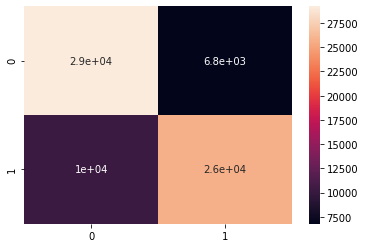

In [ ]:
# Plotando a matriz de confusão
sns.heatmap(cm, annot=True);

In [ ]:
# Verificando as chaves do histórico do treinamento
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

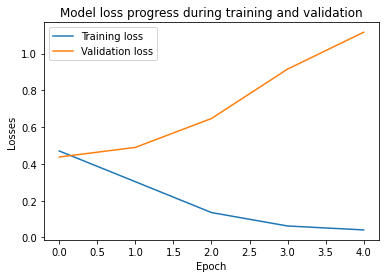

In [ ]:
# Plot da evolução da perda nas bases de treino e de validação
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

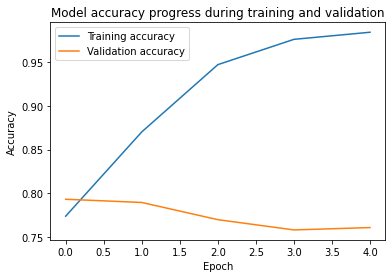

In [ ]:
# Plot da evolução da acurácia nas bases de treino e de validação
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()

## 7) Previsões

Faremos agora previsões com novos textos.

In [ ]:
# Definindo uma frase qualquer
text = 'you are so funny'

# Fazendo a tokenização
text = tokenizer.encode(text)

# Verificando o resultado
text

[10, 38, 22, 802]

In [ ]:
# Fazendo a previsão
dcnn(np.array([text]), training=False).numpy()

array([[0.99999976]], dtype=float32)

Note que temos uma probabilidade de 99% de ser uma frase positiva. Consideremos agora outra frase com sentido negativo para verificar se o algorítmo reconhecerá o sentimento.

In [ ]:
text_2 = 'i hate you'
text_2 = tokenizer.encode(text_2)
text_2

[6, 152, 77]

In [ ]:
# Fazendo a previsão
dcnn(np.array([text_2]), training=False).numpy()

array([[0.00185427]], dtype=float32)

Note que este resultado apresentou-se muito próximo de 0 e portanto ele fez uma previsão correta!